In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt


from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

/home/lcm76/.conda/envs/fl-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-23 23:56:37,324	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


**Global variables**

In [3]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [4]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

In [5]:
# Centralized experiments
centralized_experiment_batch_sizes = [8] #, 16, 32, 64, 128, 256]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 1, #100, # we have 10 epochs * 10 rounds in FL
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [6]:
# FL experiments
experiment_batch_sizes = [8] #, 16, 32, 64, 128]
cohort_sizes = [5] #, 10, 20, 50, 75]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    #"max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    #"max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR,
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-23 23:56:46,101 | flwr_core.py:103 | cid: 2530
INFO flwr 2025-02-23 23:56:46,202 | flwr_core.py:103 | cid: 2184
INFO flwr 2025-02-23 23:56:46,205 | flwr_core.py:103 | cid: 2907
INFO flwr 2025-02-23 23:56:46,208 | flwr_core.py:103 | cid: 1498
INFO flwr 2025-02-23 23:56:46,212 | flwr_core.py:103 | cid: 2338
INFO flwr 2025-02-23 23:56:46,214 | flwr_core.py:103 | cid: 2399
INFO flwr 2025-02-23 23:56:46,217 | flwr_core.py:103 | cid: 2997
INFO flwr 2025-02-23 23:56:46,220 | flwr_core.py:103 | cid: 678
INFO flwr 2025-02-23 23:56:46,224 | flwr_core.py:103 | cid: 3175
INFO flwr 2025-02-23 23:56:46,227 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-23 23:56:46,230 | flwr_core.py:103 | cid: 1571
INFO flwr 2025-02-23 23:56:46,233 | flwr_core.py:103 | cid: 2600
INFO flwr 2025-02-23 23:56:46,236 | flwr_core.py:103 | cid: 1473
INFO flwr 2025-02-23 23:56:46,239 | flwr_core.py:103 | cid: 1260
INFO flwr 2025-02-23 23:56:46,243 | flwr_core.py:103 | cid: 1603
INFO flwr 2025-02-23 23:56:46,245 | flwr_core.py:103 | cid: 2855
INFO flwr 2025-02-23 23:56:46,248 | flwr_core.py:103 | cid: 839
INFO flwr 2025-02-23 23:56:46,251 | flwr_core.py:103 | cid: 3119
INFO flwr 2025-02-23 23:56:46,254 | flwr_core.py:103 | cid: 2688
INFO flwr 2025-02-23 23:56:46,257 | flwr_core.py:103 | cid: 1494
INFO flwr 2025-02-23 23:56:46,260 | flwr_core.py:103 | cid: 447
INFO flwr 2025-02-23 23:56:46,264 | flwr_core.py:103 | cid: 1742
INFO flwr 2025-02-23 23:56:46,267 | flwr_core.py:103 | cid: 2601
INFO flwr 2025-02-23 23:56:46,270 | flwr_core.py:103 | cid: 1633
INFO flwr 2025-02-23 23:56:46,273 | flwr_core.py:103 | cid: 267
INFO flwr 2025-02-23 23:56:4

## **Experiments**

### **Centralized run with varying batch sizes**

In [7]:
centralized_experiment_results = []

for batch_size in centralized_experiment_batch_sizes:

    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )

    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))


KeyboardInterrupt: 

INFO flwr 2025-02-23 23:37:33,775 | 2950713112.py:10 | Batch size: 8
INFO flwr 2025-02-23 23:37:33,777 | 2950713112.py:11 | Accuracies: [0.03375, 0.0275]
INFO flwr 2025-02-23 23:37:33,778 | 2950713112.py:12 | Losses: [0.004703155620861893, 0.004563825089263099]
INFO flwr 2025-02-23 23:37:33,779 | 2950713112.py:13 | Noise scales: [7.050397107377648e-05, 0.00019020555191673338]
INFO flwr 2025-02-23 23:37:33,780 | 2950713112.py:14 | Critical batch size: 76.70784562716348
INFO flwr 2025-02-23 23:37:33,781 | 2950713112.py:10 | Batch size: 16
INFO flwr 2025-02-23 23:37:33,781 | 2950713112.py:11 | Accuracies: [0.02875, 0.030625]
INFO flwr 2025-02-23 23:37:33,783 | 2950713112.py:12 | Losses: [0.009337475527561978, 0.009164986794017031]
INFO flwr 2025-02-23 23:37:33,783 | 2950713112.py:13 | Noise scales: [0.0001481765793869272, 6.669980939477682e-05]
INFO flwr 2025-02-23 23:37:33,784 | 2950713112.py:14 | Critical batch size: 93.06810651116336
INFO flwr 2025-02-23 23:37:33,785 | 2950713112.py:10

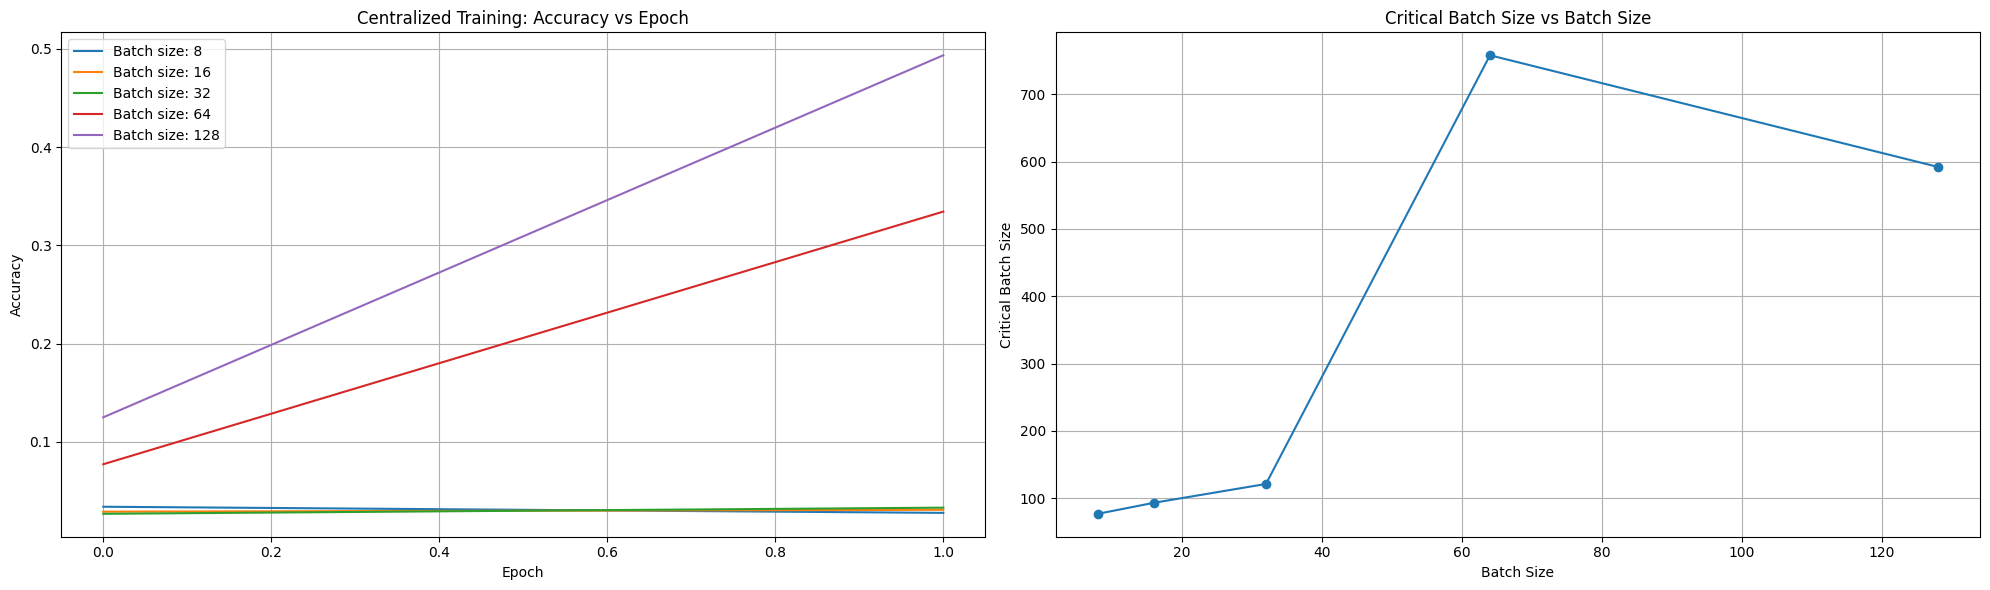

In [ ]:
centralized_total_batch_results = []
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Epoch for each batch size configuration
for batch_size, results in centralized_experiment_results:
    axes[0].plot(results["accuracies"], label=f"Batch size: {batch_size}")
    bcrit = compute_critical_batch(results["noise_scales"], constant=0.01)
    centralized_total_batch_results.append((batch_size, bcrit))
    # Logging information (optional)
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Accuracies: {results['accuracies']}")
    log(INFO, f"Losses: {results['losses']}")
    log(INFO, f"Noise scales: {results['noise_scales']}")
    log(INFO, f"Critical batch size: {bcrit}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Centralized Training: Accuracy vs Epoch")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Critical Batch Size vs Batch Size
batch_sizes = [bs for bs, _ in centralized_total_batch_results]
bcrit_values = [bcrit for _, bcrit in centralized_total_batch_results]

axes[1].plot(batch_sizes, bcrit_values, marker='o')
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Critical Batch Size")
axes[1].set_title("Critical Batch Size vs Batch Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

### **FL run with varying batch sizes**

In [9]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_batch_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-02-23 23:37:34,194 | flwr_core.py:103 | cid: 2530
INFO flwr 2025-02-23 23:37:34,198 | flwr_core.py:103 | cid: 2184
INFO flwr 2025-02-23 23:37:34,201 | flwr_core.py:103 | cid: 2907
INFO flwr 2025-02-23 23:37:34,203 | flwr_core.py:103 | cid: 1498
INFO flwr 2025-02-23 23:37:34,205 | flwr_core.py:103 | cid: 2338
INFO flwr 2025-02-23 23:37:34,207 | flwr_core.py:103 | cid: 2399
INFO flwr 2025-02-23 23:37:34,209 | flwr_core.py:103 | cid: 2997
INFO flwr 2025-02-23 23:37:34,211 | flwr_core.py:103 | cid: 678
INFO flwr 2025-02-23 23:37:34,214 | flwr_core.py:103 | cid: 3175
INFO flwr 2025-02-23 23:37:34,216 | flwr_core.py:103 | cid: 1363
INFO flwr 2025-02-23 23:37:34,219 | flwr_core.py:103 | cid: 1571
INFO flwr 2025-02-23 23:37:34,221 | flwr_core.py:103 | cid: 2600
INFO flwr 2025-02-23 23:37:34,223 | flwr_core.py:103 | cid: 1473
INFO flwr 2025-02-23 23:37:34,225 | flwr_core.py:103 | cid: 1260
INFO flwr 2025-02-23 23:37:34,228 | flwr_core.py:103 | cid: 1603
INFO flwr 2025-02-23 23:37

INFO flwr 2025-02-23 23:37:34,269 | flwr_core.py:103 | cid: 1652
INFO flwr 2025-02-23 23:37:34,271 | flwr_core.py:103 | cid: 3020
INFO flwr 2025-02-23 23:37:34,273 | flwr_core.py:103 | cid: 1273
INFO flwr 2025-02-23 23:37:34,276 | flwr_core.py:103 | cid: 2718
INFO flwr 2025-02-23 23:37:34,279 | flwr_core.py:103 | cid: 73
INFO flwr 2025-02-23 23:37:34,283 | flwr_core.py:103 | cid: 1446
INFO flwr 2025-02-23 23:37:34,285 | flwr_core.py:103 | cid: 2434
INFO flwr 2025-02-23 23:37:34,288 | flwr_core.py:103 | cid: 485
INFO flwr 2025-02-23 23:37:34,291 | flwr_core.py:103 | cid: 1887
INFO flwr 2025-02-23 23:37:34,293 | flwr_core.py:103 | cid: 1009
INFO flwr 2025-02-23 23:37:34,296 | flwr_core.py:103 | cid: 701
INFO flwr 2025-02-23 23:37:34,300 | flwr_core.py:103 | cid: 1285
INFO flwr 2025-02-23 23:37:34,303 | flwr_core.py:103 | cid: 2782
INFO flwr 2025-02-23 23:37:34,306 | flwr_core.py:103 | cid: 2828
INFO flwr 2025-02-23 23:37:34,308 | flwr_core.py:103 | cid: 2476
INFO flwr 2025-02-23 23:37:34

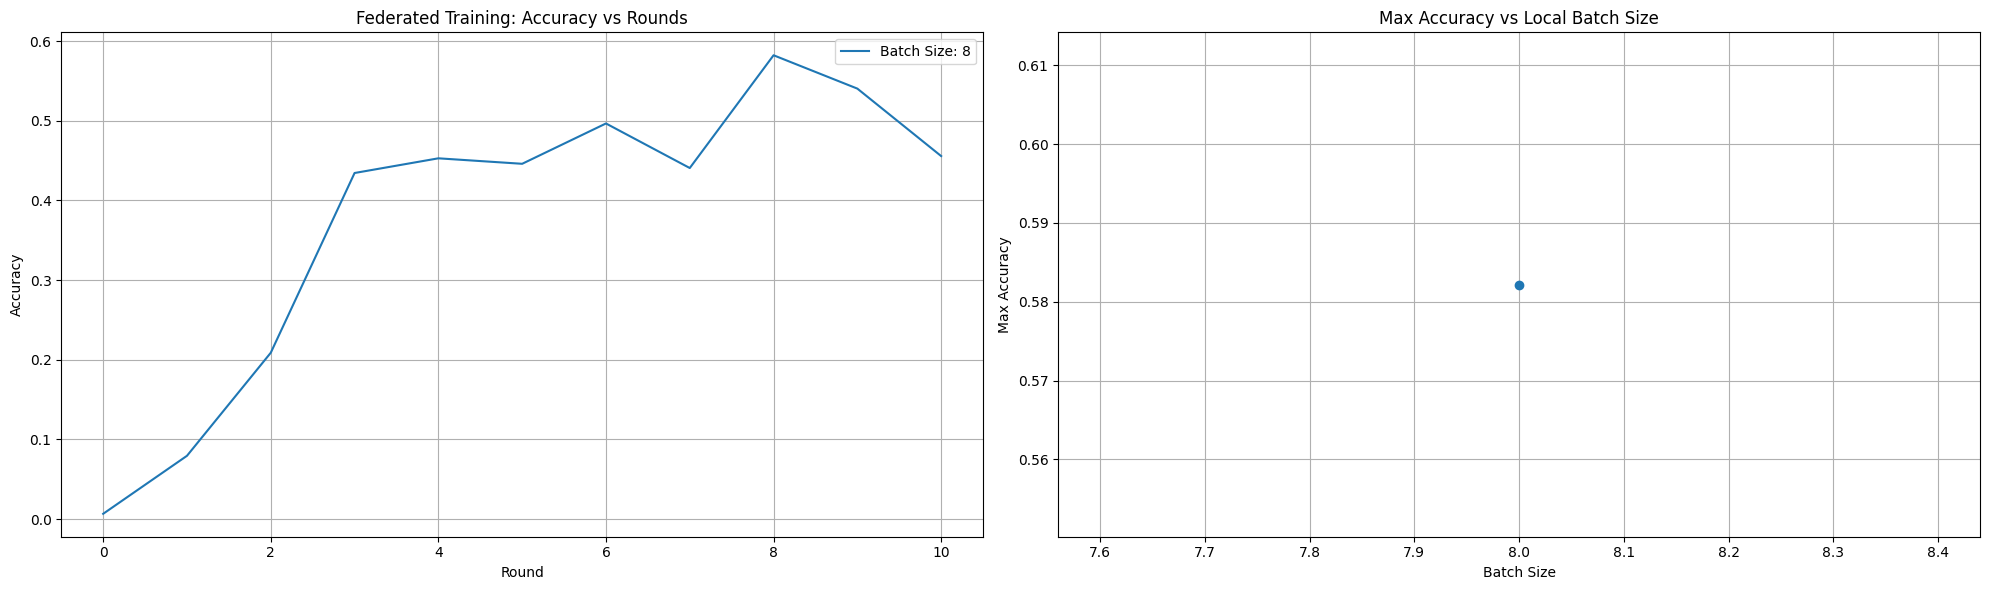

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for batch_size, params, hist in total_batch_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Batch Size: {batch_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Batch Size
batch_sizes = []
max_accuracies = []
for batch_size, params, hist in total_batch_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        batch_sizes.append(batch_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(batch_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Local Batch Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [11]:
for batch_size, params, hist in total_batch_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches)) 

Batch size:  8
--- 15.730289951901147
--- 18.7389443416473
--- 15.82288102809525
--- 18.505440326906346
--- 13.792535773479635
--- 15.402164753048188
--- 20.706639987234645
--- 18.947832678526858
--- 18.274727430976945
--- 14.010327232993129
16.993178350480942


When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

## **Running FL with varying cohort sizes**

In [ ]:
total_cohort_results = []

for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-23 23:40:30,915 | experiments_simulation.py:133 | FL will execute for 10 rounds
INFO flwr 2025-02-23 23:40:30,918 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-23 23:40:30,919 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-23 23:40:30,920 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-23 23:40:30,922 | server_returns_parameters.py:84 | Evaluating initial parameters


 11%|█         | 100/891 [00:01<00:09, 79.53it/s]
INFO flwr 2025-02-23 23:40:32,430 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-02-23 23:40:32,430 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-23 23:40:32,431 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)
INFO flwr 2025-02-23 23:40:32,432 | flwr_core.py:103 | cid: 937
INFO flwr 2025-02-23 23:40:32,433 | flwr_core.py:103 | cid: 1167
INFO flwr 2025-02-23 23:40:32,436 | flwr_core.py:103 | cid: 2167
INFO flwr 2025-02-23 23:40:32,442 | flwr_core.py:103 | cid: 2471
INFO flwr 2025-02-23 23:40:32,446 | flwr_core.py:103 | cid: 1287
DEBUG flwr 2025-02-23 23:40:37,281 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures
 11%|█         | 100/891 [00:01<00:08, 88.30it/s]
INFO flwr 2025-02-23 23:40:38,659 | server_returns_parameters.py:120 | fit progress: (1, 384.740

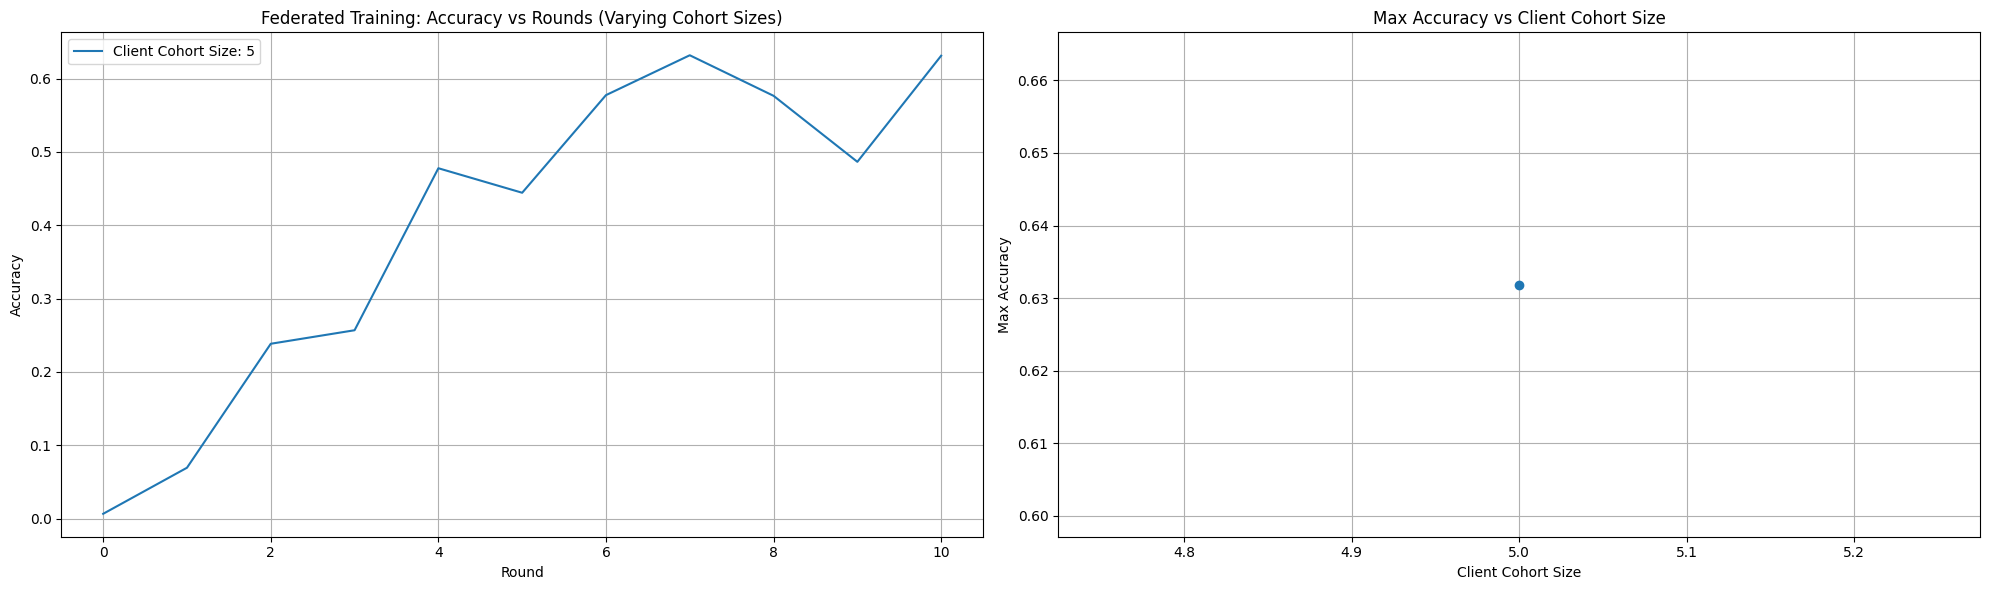

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Rounds for each client cohort size
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Client Cohort Size: {cohort_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds (Varying Cohort Sizes)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Client Cohort Size
cohort_sizes = []
max_accuracies = []
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        cohort_sizes.append(cohort_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(cohort_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Client Cohort Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Client Cohort Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.

**$\beta_\text{simple}$ integration into Federated Learning runs**


To implement the actual $\beta_\text{simple}$ ($\beta_\text{simple} \approx \beta_\text{crit}$) computation, we would need to change the client fit fn to return the gradients after training, and we would need to aggregate them in the server somehow.

In summary, we need to somehow get them to the hist or params object, and figure out a way to aggregate them.

This appears to give us a good estimate of the critical batch size. According to this estimates, the ideal batch size appears to be somewhere in the 16-64, and the optimal batch size we observe is actually 32, which is right in the middle of the range.

In [ ]:
for cohort_size, params, hist in total_cohort_results:
    print("Cohort size: ", cohort_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches))       

Cohort size:  5
--- 45.46054326374836
--- 38.13080660560482
--- 88.48317906566389
--- 21.77958402713009
--- 20.166672224093972
--- 13.169443510724976
--- 20.479747349507473
--- 25.134488433173978
--- 39.58223287273709
--- 15.399299717357898
32.778599706974255
